In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd "~/parkrec"

/home/jorgen/parkrec


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from pathlib import Path
import nibabel
from datetime import datetime

In [4]:
patientid = "PAT_001"
concentration_dirname = "CONCS_synthetic"
simulation = "diffusion"

patdir = Path("DATA") / patientid
concentrations = sorted((patdir / "CONCS_synthetic").glob("*.mgz"))
diffusion = sorted((patdir / "SIMULATION").glob(f"{simulation}*.nii.gz"))

In [5]:
def create_mri_dataframe(
    filepath: Path,
    dtype: type,
    valname: str,
):
    mri_vol = nibabel.load(filepath)
    im = mri_vol.get_fdata().astype(dtype)
    IJK = np.array(list(np.ndindex(im.shape)))
    #    vox2ras = mri_vol.header.get_vox2ras()  # Kept until first commit, for reference
    #    XYZ = nibabel.affines.apply_affine(vox2ras, IJK)
    df = pd.DataFrame(
        {
            **{
                key: pd.Series(IJK[:, num], dtype=int)
                for num, key in enumerate(("i", "j", "k"))
            },
            valname: pd.Series(im.reshape(-1), dtype=dtype),
        }
    )
    return df


def is_patient_dir(path: Path):
    return path.is_dir() and (re.match("PAT_\d{3}", path.name) is not None)


def read_concentrations_file(filepath: Path, *args, **kwargs):
    concentrations_file = Path(filepath)
    columns = pd.read_csv(concentrations_file, index_col=0, nrows=0).columns.tolist()
    # TODO: Move this to a separate function
    dtypes = {
        key: (np.ushort if key in ("i", "j", "k", "aseg") else np.single)
        for key in columns
    }
    return pd.read_csv(concentrations_file, dtype=dtypes, *args, **kwargs)


def flatten_dataframe(dataframe: pd.DataFrame) -> pd.Series:
    mi = pd.MultiIndex.from_product([dataframe.columns, dataframe.index])
    return pd.Series(dataframe.to_numpy().flatten(order="F"), index=mi)


## Create Simulation Statistics 

In [6]:
outputname = f"{simulation}.csv"
statsdir = patdir / "STATISTICS"
statsdir.mkdir(exist_ok=True)

aseg_volume = patdir / "mri" / "aseg.mgz"
aseg_series = pd.Series(
    nibabel.load(aseg_volume).get_fdata().astype(int).reshape(-1)
)
df = create_mri_dataframe(aseg_volume, np.ushort, "aseg")
for concfile, namefile in zip(diffusion, concentrations):
    timestamp = datetime.strptime(namefile.stem, "%Y%m%d_%H%M%S")
    im = nibabel.load(concfile).get_fdata().astype(np.single)

    df = df.assign(
        **{str(pd.to_datetime(timestamp)): pd.Series(im.reshape(-1), dtype=float)}
    )
print(df.head())
df.to_csv(statsdir / outputname, index=False)
df.head(10).to_csv(statsdir / f"{simulation}_test.csv", index=False)

   i  j  k  aseg  2023-01-23 07:50:13  2023-01-23 14:39:58  \
0  0  0  0     0                  0.0                  0.0   
1  0  0  1     0                  0.0                  0.0   
2  0  0  2     0                  0.0                  0.0   
3  0  0  3     0                  0.0                  0.0   
4  0  0  4     0                  0.0                  0.0   

   2023-01-24 08:45:08  2023-01-25 09:08:23  2023-01-26 07:37:44  
0                  0.0                  0.0                  0.0  
1                  0.0                  0.0                  0.0  
2                  0.0                  0.0                  0.0  
3                  0.0                  0.0                  0.0  
4                  0.0                  0.0                  0.0  


## Create BoxPlots

In [7]:
from create_dataframe import read_concentrations_file
from seg_groups import default_segmentation_groups
import pprint
import pandas as pd
import matplotlib.patheffects as pe

def xth_percentile(x):
    def perc(y):
        return y.quantile(x)
    return perc

def p10(x):
    return x.quantile(0.1)

def p90(x):
    return x.quantile(0.9)

def flatten_dataframe(dataframe: pd.DataFrame) -> pd.Series:
    mi = pd.MultiIndex.from_product([dataframe.columns, dataframe.index])
    return pd.Series(dataframe.to_numpy().flatten(order="F"), index=mi)


def create_group_statistics(
    patientid,
    csvfile,
    outputname,
    seg_groups=None,
):
    if seg_groups is None:
        seg_groups = default_segmentation_groups()
    aggregations = ["median", "mean", "std", p10, p90]
    drop_cols = ["i", "j", "k"]
    df = read_concentrations_file(
        f"DATA/{patientid}/STATISTICS/{csvfile}"
    ).dropna().drop(drop_cols, axis=1)

    stat = df.dropna().groupby(["aseg"]).agg(aggregations)
    for group, aseg_idx in seg_groups.items():
        mask = df["aseg"].isin(seg_groups[group])
        df_group  = df[mask].drop("aseg", axis=1)
        if df_group.size> 0:
            gr_stats = df_group.agg(aggregations)
            stat.loc[group] = flatten_dataframe(gr_stats)
    stat.to_csv(f"DATA/{patientid}/STATISTICS/{outputname}", index=False)
    return stat


def patient_aseg_group_data(patient, patdir, group, csvfile):
    drop_cols = ["i", "j", "k"]
    df = read_concentrations_file(
        patdir / f"STATISTICS/{csvfile}"
    ).dropna().drop(drop_cols, axis=1)
    mask = df["aseg"].isin(seg_groups[group])
    out = df[mask].drop(["aseg"], axis=1).assign(patientid=patient)
    out.columns=[0, 7, 26, 50, 72, "patientid"]
    return out


def melt_patient_group_data(patients, group, csvfile, seg_groups=None):
    if seg_groups is None:
        seg_groups = default_segmentation_groups()
    df = pd.concat(
        [patient_aseg_group_data(pat, patdir, group, csvfile) for pat, patdir in patients.items()],
        ignore_index=True,
    )
    return pd.melt(df, id_vars=['patientid'], var_name="hours", value_name="median_concentration")

def median_value_patient_group_data(patient, group, csvfile):
    return patient_aseg_group_data(
        patient,
        Path(f"DATA/{patient}"),
        group,
        csvfile
    ).drop(["patientid"], axis=1).median()

def get_all_labels(patientid, csvfile):
    drop_cols = ["i", "j", "k"]
    df = read_concentrations_file(
        f"DATA/{patientid}/STATISTICS/{csvfile}"
    ).dropna().drop(drop_cols, axis=1)
    return sorted(df["aseg"].unique())


from create_dataframe import read_concentrations_file
from seg_groups import default_segmentation_groups
import pprint
import pandas as pd
import seaborn

seg_groups = default_segmentation_groups()
seg_groups.pop("csf")
pprint.pprint(seg_groups)
seg_groups["whole-brain"] = get_all_labels("PAT_002", "concentrations.csv")


patients = {
    "PAT_001": Path("DATA/PAT_001"),
    "PAT_002": Path("DATA/PAT_002"),
}

figpath = Path("report-images")

{'accumbens': [26, 58],
 'amygdala': [18, 54],
 'basal-ganglias': [11, 50, 12, 51, 13, 52, 17, 53, 18, 54, 26, 58],
 'caudate': [11, 50],
 'cerebellum': [7, 8, 46, 47],
 'corpus-callosum': [251, 252, 253, 254, 255],
 'cortex-cerebellar': [8, 47],
 'cortex-cerebral': [3, 42],
 'gray-matter': [3, 42, 8, 47, 11, 50, 12, 51, 13, 52, 17, 53, 18, 54, 26, 58],
 'hippocampus': [17, 53],
 'pallidum': [13, 52],
 'putamen': [12, 51],
 'white-matter': [2, 41, 7, 46, 77, 78, 70, 77, 78, 79, 80, 100, 109],
 'wm-cerebellar': [7, 46],
 'wm-cerebral': [2, 41],
 'wm-hypointensities': [77, 78, 70],
 'wm-pathological': [77, 78, 79, 80, 100, 109]}


## All Patients and Data

Plotting  white-matter


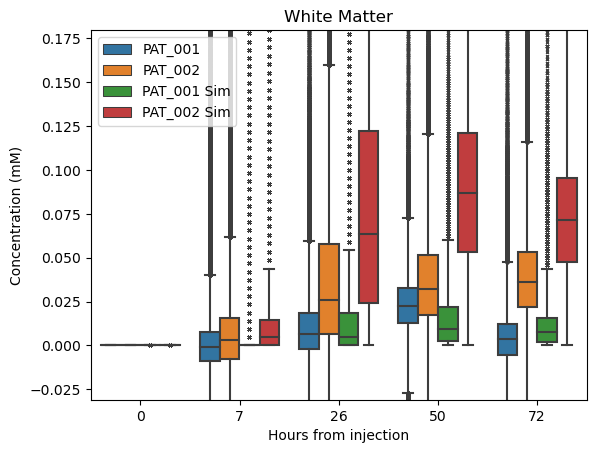

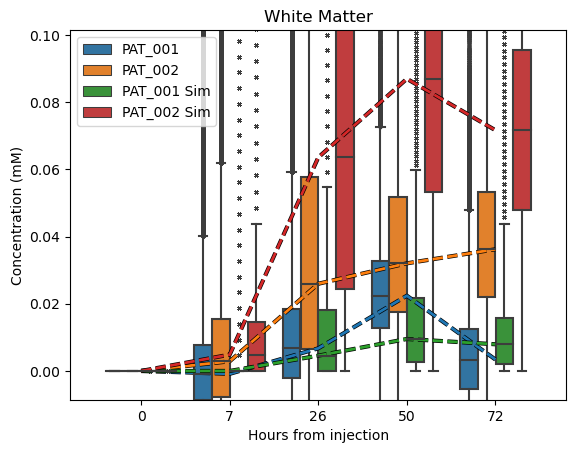

Plotting  gray-matter


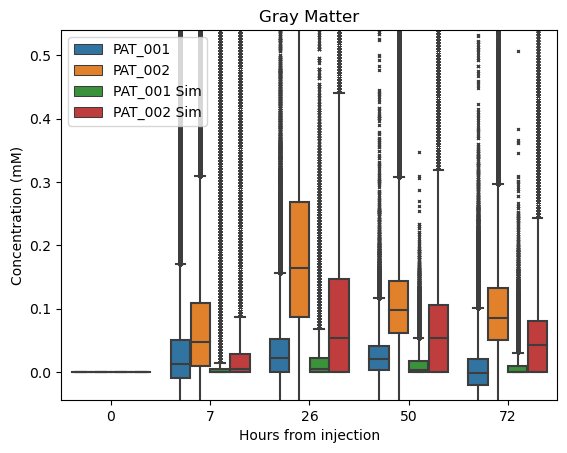

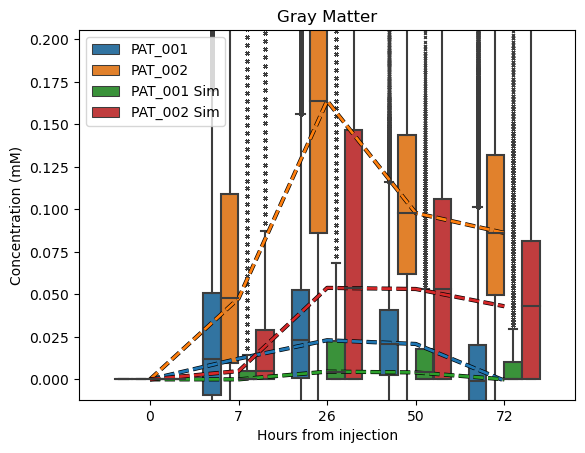

Plotting  basal-ganglias


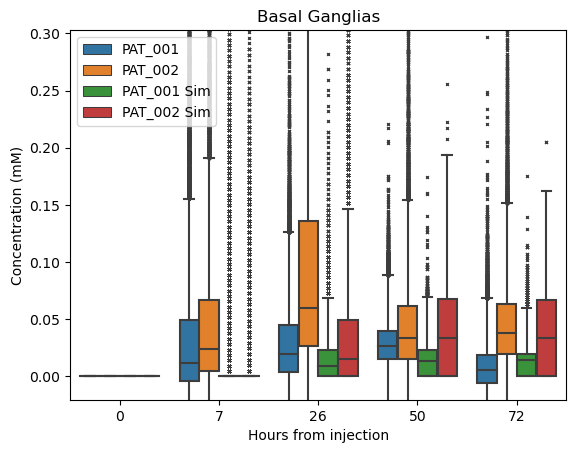

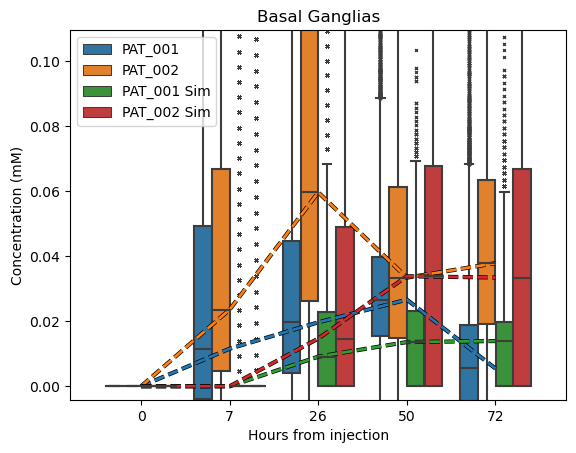

Plotting  whole-brain


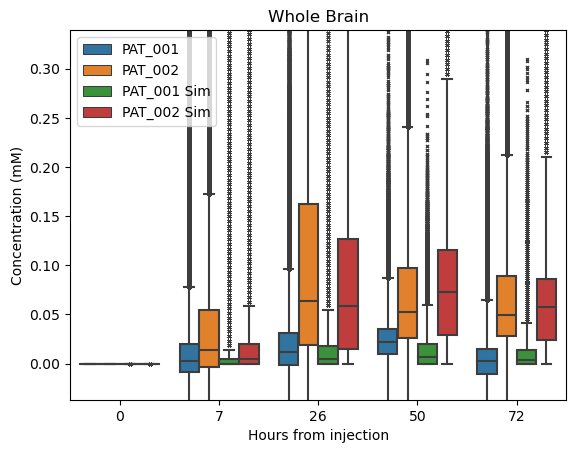

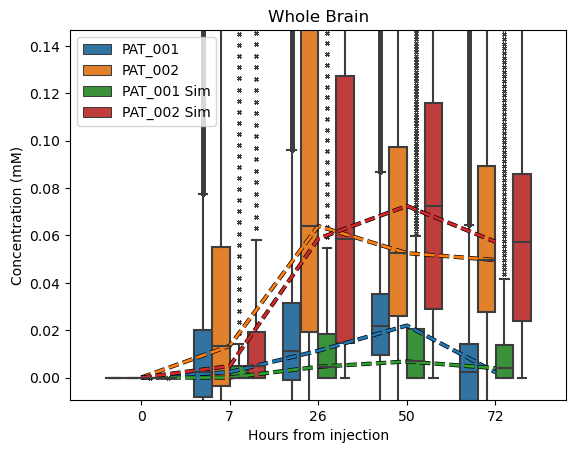

In [8]:
import matplotlib.patheffects as pe
path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()]
groups=["white-matter", "gray-matter", "basal-ganglias", "whole-brain"]
for groupname in groups:
    print("Plotting ", groupname)
    datamelt = melt_patient_group_data(patients, groupname, "concentrations.csv", seg_groups)
    simulated = melt_patient_group_data(patients, groupname, "diffusion.csv", seg_groups)
    simulated["patientid"] = simulated["patientid"].apply(lambda x: f"{x} Sim")
    melted = pd.concat((datamelt, simulated))

    fig, ax = plt.subplots()


    g = seaborn.boxplot(
        melted,
        x='hours',
        y='median_concentration',
        hue='patientid',
        flierprops={
            "marker": "x",
            "color": "r"
        },
        fliersize=2.0,
        whis=2
    )
    title = groupname.replace("-", " ").title()
    ax.legend(title="", loc="upper left")
    ax.set_title(title)
    ax.set_ylim(
        melted["median_concentration"].quantile(0.01),
        melted["median_concentration"].quantile(0.99)
    )
    ax.set_ylabel("Concentration (mM)")
    ax.set_xlabel("Hours from injection")

    fig.savefig(figpath / f"boxplot_{groupname}_sim_all.png", bbox_inches="tight")
    plt.show(fig)


    fig, ax = plt.subplots()

    g = seaborn.boxplot(
        melted,
        x='hours',
        y='median_concentration',
        hue='patientid',
        flierprops={
            "marker": "x",
            "color": "r"
        },
        fliersize=2.0,
        whis=2
    )
    title = groupname.replace("-", " ").title()
    for pat in patients:
        median_curve = median_value_patient_group_data(pat, groupname, "concentrations.csv")
        ax.plot(median_curve.values, ls="--", lw=2, path_effects=path_effects)
    for pat in patients:
        median_curve = median_value_patient_group_data(pat, groupname, "diffusion.csv")
        ax.plot(median_curve.values, ls="--", lw=2, path_effects=path_effects)
    ax.legend(title="", loc="upper left")
    ax.set_title(title)
    ax.set_ylim(
        melted["median_concentration"].quantile(0.05),
        melted["median_concentration"].quantile(0.95)
    )
    ax.set_ylabel("Concentration (mM)")
    ax.set_xlabel("Hours from injection")

    fig.savefig(figpath / f"boxplot_{groupname}_curves_sim_all.png", bbox_inches="tight")
    plt.show(fig)


### Patient 1

Plotting  white-matter


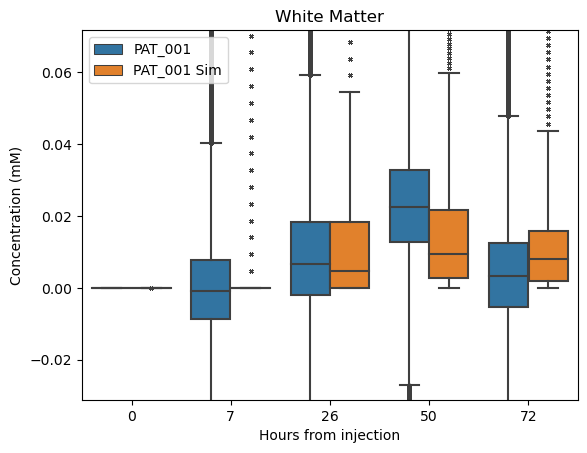

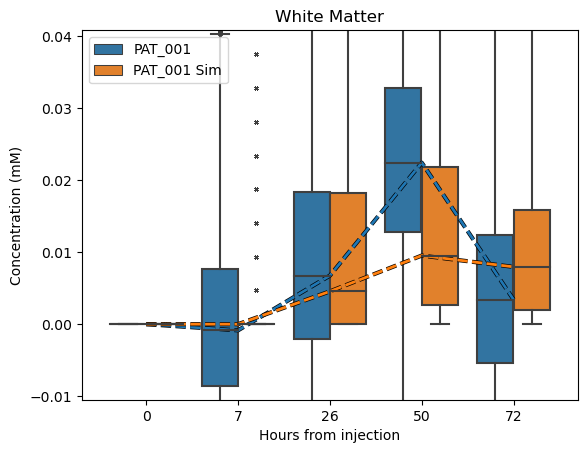

Plotting  gray-matter


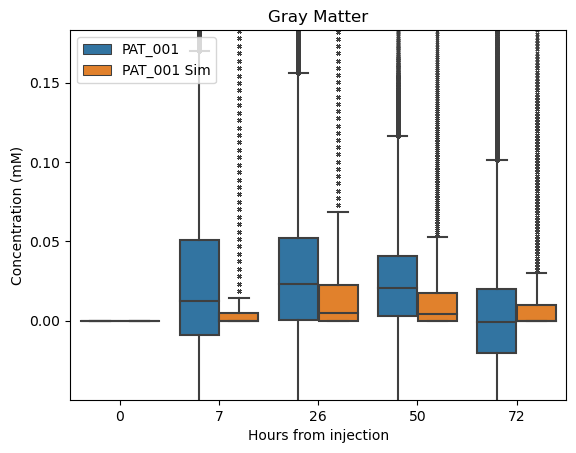

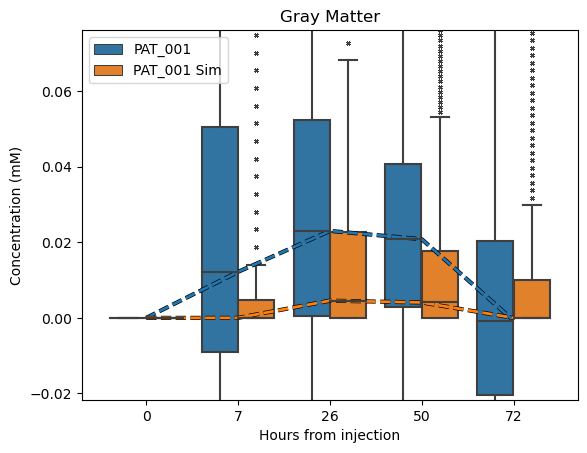

Plotting  basal-ganglias


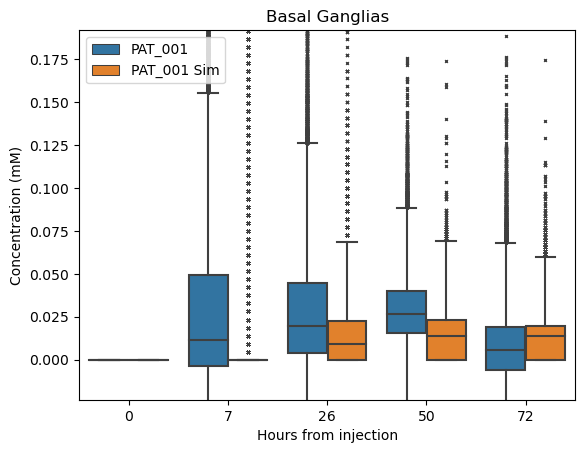

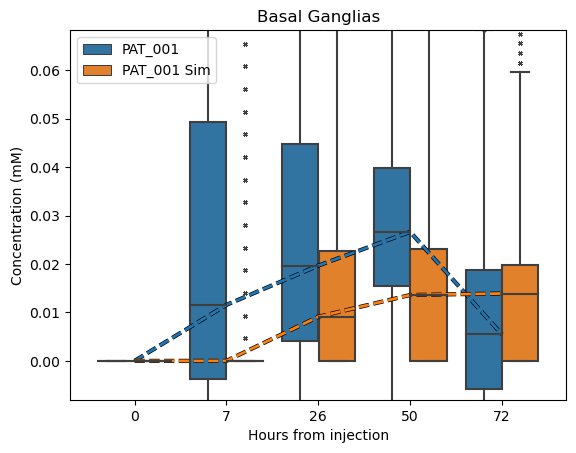

Plotting  whole-brain


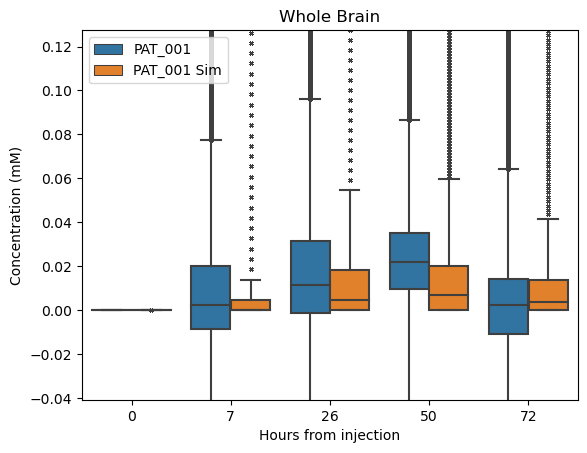

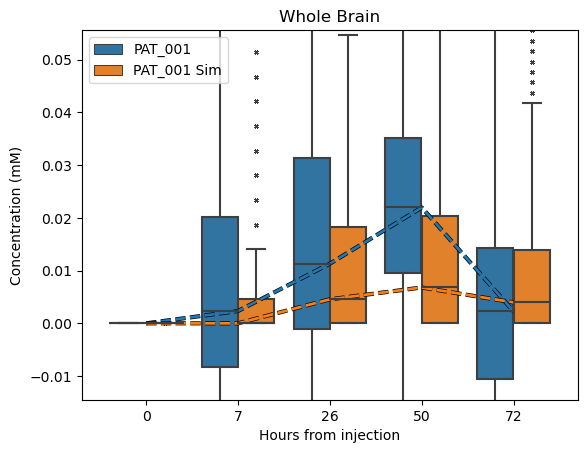

In [9]:
import matplotlib.patheffects as pe
path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()]
groups=["white-matter", "gray-matter", "basal-ganglias", "whole-brain"]
patients = {
    "PAT_001": Path("DATA/PAT_001"),
}
for groupname in groups:
    print("Plotting ", groupname)
    datamelt = melt_patient_group_data(patients, groupname, "concentrations.csv", seg_groups)
    simulated = melt_patient_group_data(patients, groupname, "diffusion.csv", seg_groups)
    simulated["patientid"] = simulated["patientid"].apply(lambda x: f"{x} Sim")
    melted = pd.concat((datamelt, simulated))

    fig, ax = plt.subplots()


    g = seaborn.boxplot(
        melted,
        x='hours',
        y='median_concentration',
        hue='patientid',
        flierprops={
            "marker": "x",
            "color": "r"
        },
        fliersize=2.0,
        whis=2
    )
    title = groupname.replace("-", " ").title()
    ax.legend(title="", loc="upper left")
    ax.set_title(title)
    ax.set_ylim(
        melted["median_concentration"].quantile(0.01),
        melted["median_concentration"].quantile(0.99)
    )
    ax.set_ylabel("Concentration (mM)")
    ax.set_xlabel("Hours from injection")

    fig.savefig(figpath / f"boxplot_{groupname}_sim_PAT_001.png", bbox_inches="tight")
    plt.show(fig)


    fig, ax = plt.subplots()

    g = seaborn.boxplot(
        melted,
        x='hours',
        y='median_concentration',
        hue='patientid',
        flierprops={
            "marker": "x",
            "color": "r"
        },
        fliersize=2.0,
        whis=2
    )
    title = groupname.replace("-", " ").title()
    for pat in patients:
        median_curve = median_value_patient_group_data(pat, groupname, "concentrations.csv")
        ax.plot(median_curve.values, ls="--", lw=2, path_effects=path_effects)
    for pat in patients:
        median_curve = median_value_patient_group_data(pat, groupname, "diffusion.csv")
        ax.plot(median_curve.values, ls="--", lw=2, path_effects=path_effects)
    ax.legend(title="", loc="upper left")
    ax.set_title(title)
    ax.set_ylim(
        melted["median_concentration"].quantile(0.05),
        melted["median_concentration"].quantile(0.95)
    )
    ax.set_ylabel("Concentration (mM)")
    ax.set_xlabel("Hours from injection")

    fig.savefig(figpath / f"boxplot_{groupname}_curves_sim_PAT_001.png", bbox_inches="tight")
    plt.show(fig)

### Patient 002

Plotting  white-matter


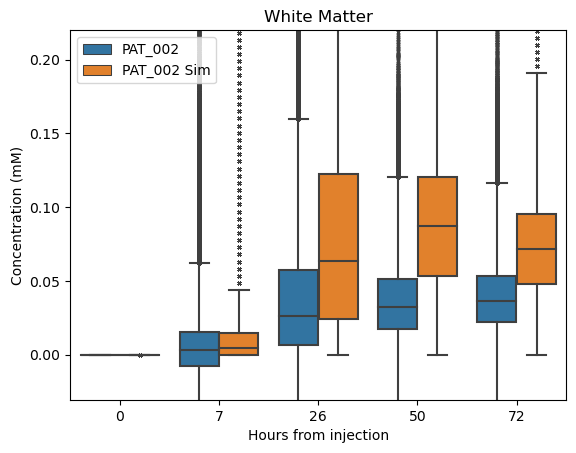

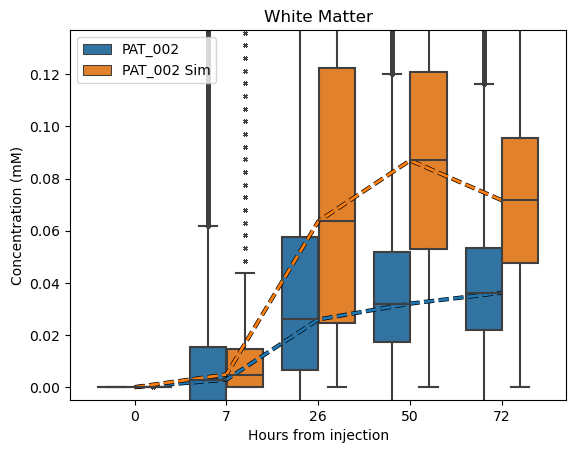

Plotting  gray-matter


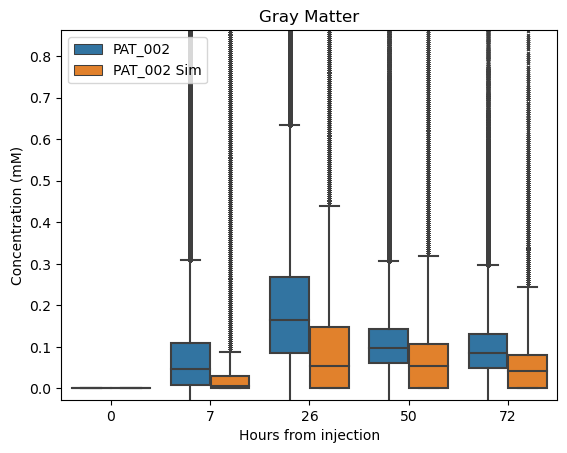

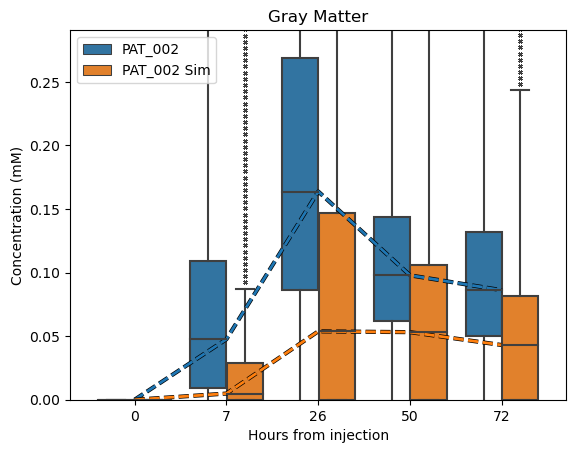

Plotting  basal-ganglias


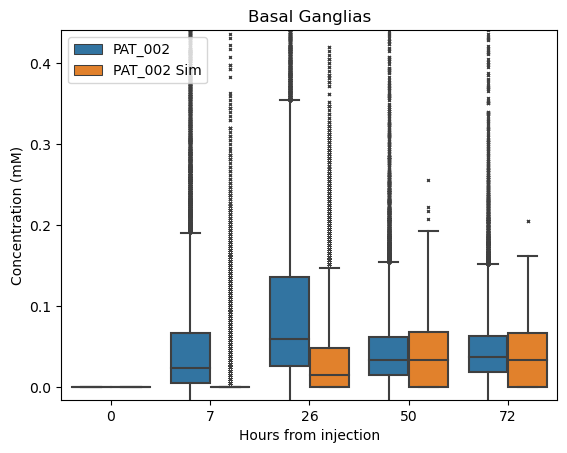

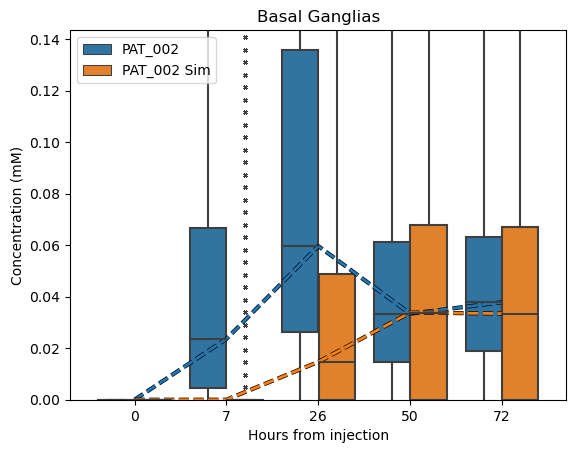

Plotting  whole-brain


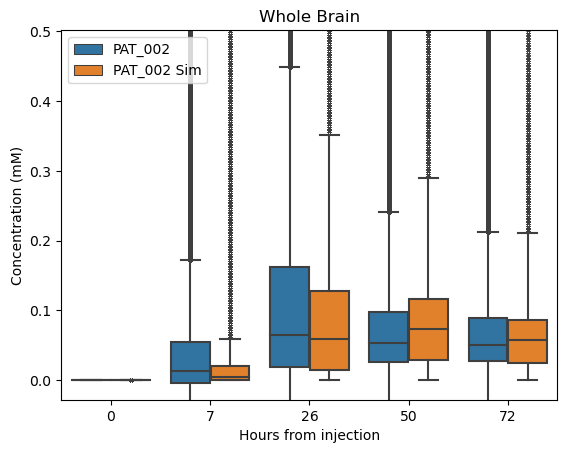

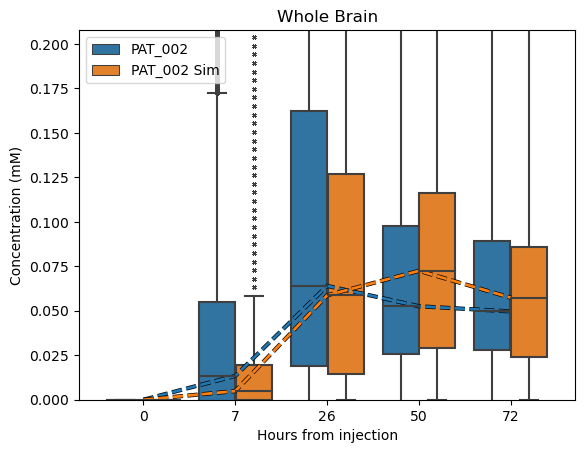

In [10]:
import matplotlib.patheffects as pe
path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()]
groups=["white-matter", "gray-matter", "basal-ganglias", "whole-brain"]
patients = {
    "PAT_002": Path("DATA/PAT_002"),
}
for groupname in groups:
    print("Plotting ", groupname)
    datamelt = melt_patient_group_data(patients, groupname, "concentrations.csv", seg_groups)
    simulated = melt_patient_group_data(patients, groupname, "diffusion.csv", seg_groups)
    simulated["patientid"] = simulated["patientid"].apply(lambda x: f"{x} Sim")
    melted = pd.concat((datamelt, simulated))

    fig, ax = plt.subplots()


    g = seaborn.boxplot(
        melted,
        x='hours',
        y='median_concentration',
        hue='patientid',
        flierprops={
            "marker": "x",
            "color": "r"
        },
        fliersize=2.0,
        whis=2
    )
    title = groupname.replace("-", " ").title()
    ax.legend(title="", loc="upper left")
    ax.set_title(title)
    ax.set_ylim(
        melted["median_concentration"].quantile(0.01),
        melted["median_concentration"].quantile(0.99)
    )
    ax.set_ylabel("Concentration (mM)")
    ax.set_xlabel("Hours from injection")
    fig.savefig(figpath / f"boxplot_{groupname}_sim_PAT_002.png", bbox_inches="tight")
    plt.show(fig)


    fig, ax = plt.subplots()

    g = seaborn.boxplot(
        melted,
        x='hours',
        y='median_concentration',
        hue='patientid',
        flierprops={
            "marker": "x",
            "color": "r"
        },
        fliersize=2.0,
        whis=2
    )
    title = groupname.replace("-", " ").title()
    for pat in patients:
        median_curve = median_value_patient_group_data(pat, groupname, "concentrations.csv")
        ax.plot(median_curve.values, ls="--", lw=2, path_effects=path_effects)
    for pat in patients:
        median_curve = median_value_patient_group_data(pat, groupname, "diffusion.csv")
        ax.plot(median_curve.values, ls="--", lw=2, path_effects=path_effects)
    ax.legend(title="", loc="upper left")
    ax.set_title(title)
    ax.set_ylim(
        melted["median_concentration"].quantile(0.05),
        melted["median_concentration"].quantile(0.95)
    )
    ax.set_ylabel("Concentration (mM)")
    ax.set_xlabel("Hours from injection")

    fig.savefig(figpath / f"boxplot_{groupname}_curves_sim_PAT_002.png", bbox_inches="tight")
    plt.show(fig)
